In [1]:
!pip install pandas-datareader==0.10.0

## IMPORT RAY TUNE

#### Used for Hyper parameter search 
#### Tune leverages the distributed execution capabilities of Ray, 
#### Allowing it to scale hyperparameter tuning across multiple CPUs, GPUs, or nodes.

In [2]:
!pip install 'ray[tune]'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 1.6 MB/s eta 0:00:00


## IMPORTS

In [3]:
# data preprocessing
import datetime
import pandas_datareader.data as pdr
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy
import matplotlib.pyplot as plt

# deep learning
import torch
from torch.autograd import Variable
import torch.nn as nn

# hyperparameter tuning
import ray
from ray import tune

import yfinance as yf
import pandas as pd
import datetime

In [4]:
file_path = '/kaggle/input/comments-llm/comments_llm_finetune_Pred.csv'
df = pd.read_csv(file_path)
df.predictions.value_counts(normalize=True)

predictions
1    0.591375
0    0.408625
Name: proportion, dtype: float64

In [5]:
df

,id,body,created_at,entities,likes,target,logits,predictions
0,422295553,TSLA best to buy early l this will rise into d...,2021-12-31,Bullish,1.0,1,"[-0.49851578, 2.493009]",1
1,422299819,TSLA clown,2021-12-31,Bullish,NaN,1,"[2.7525167, -1.1106727]",0
2,422290556,TSLA 2022 Epic RadioMediaPodcast Revolution !!...,2021-12-31,Bullish,NaN,1,"[-0.7456628, 3.3697927]",1
3,422354247,TSLA keep buying please,2021-12-31,Bullish,NaN,1,"[2.6817956, 1.6763675]",0
4,422474163,TSLA to recall about half the number of cars t...,2021-12-31,Bearish,2.0,0,"[1.2388923, -0.8642001]",0
...,...,...,...,...,...,...,...,...
19705,440083151,PLTR SPY NIO TSLA Sheesh. Just check for the f...,2022-03-01,Bullish,13.0,1,"[-0.096702814, -0.74315286]",0
19706,440093129,TSLA where are the pictures of happy refugees ...,2022-03-01,Bearish,2.0,0,"[2.0175295, -0.63785434]",0
19707,440085478,STRR MULN TSLA AAPL,2022-03-01,Bullish,3.0,1,"[2.9611123, 5.992332]",1
19708,440086036,TSLA stock is gonna run like crazy from here o...,2022-03-01,Bullish,2.0,1,"[1.4454808, 2.4294212]",1


In [6]:
class_weights=(1/df.predictions.value_counts(normalize=True).sort_index()).tolist()
class_weights=torch.tensor(class_weights)
class_weights=class_weights/class_weights.sum()
class_weights

tensor([0.5914, 0.4086])

## ADDING SENTIMENT SCORE TO DATAFRAME

In [7]:
import pandas as pd
import numpy as np

# Load the CSV file
file_path = '/kaggle/input/comments-llm/comments_llm_finetune_Pred.csv'
data = pd.read_csv(file_path)

# Split the logits column into two separate columns, treating 0th index as bearish and 1st as bullish
data[['logits_bearish', 'logits_bullish']] = data['logits'].str.strip('[]').str.split(',', expand=True).astype(float)

#Define a function to calculate sentiment score from logits
def calculate_sentiment_score(logits_bearish, logits_bullish):      #1111111111111111111111111111111111
    exp_bullish = np.exp(logits_bullish)
    exp_bearish = np.exp(logits_bearish)     #79 for both type of average
    prob_bullish = exp_bullish / (exp_bullish + exp_bearish)
    prob_bearish = exp_bearish / (exp_bullish + exp_bearish)

    if prob_bullish >= prob_bearish:
        sentiment_score = prob_bullish
    else:
        sentiment_score = -prob_bearish

    return sentiment_score


x1 = class_weights[0].item()
x2 = class_weights[1].item()

weight_bearish = round(x1, 1)*10
weight_bullish = round(x2, 1)*10
# Calculate sentiment scores and add them to the DataFrame
data['sentiment_score'] = data.apply(
    lambda row: calculate_sentiment_score(row['logits_bearish'], row['logits_bullish']), axis=1
)

data['weighted_sentiment'] = data.apply(
    lambda row: row['sentiment_score'] * weight_bearish if row['sentiment_score'] < 0
                else row['sentiment_score'] * weight_bullish,
    axis=1
)

# Save the updated DataFrame with sentiment scores to a new CSV file
output_file_path = '/kaggle/working/updated_stock_comments_with_sentiment_scores.csv'
data.to_csv(output_file_path, index=False)

date_wise_avg = data.groupby('created_at')['weighted_sentiment'].sum().reset_index()

# Save the date-wise average sentiment scores to a new CSV file
output_avg_file_path = '/kaggle/working/date_wise_avg_sentiment_scores.csv'
date_wise_avg.to_csv(output_avg_file_path, index=False)

print(f"Sentiment scores have been calculated and saved to {output_file_path}")
print(f"Date-wise average sentiment scores have been calculated and saved to {output_avg_file_path}")


Sentiment scores have been calculated and saved to /kaggle/working/updated_stock_comments_with_sentiment_scores.csv
Date-wise average sentiment scores have been calculated and saved to /kaggle/working/date_wise_avg_sentiment_scores.csv


In [8]:
data

,id,body,created_at,entities,likes,target,logits,predictions,logits_bearish,logits_bullish,sentiment_score,weighted_sentiment
0,422295553,TSLA best to buy early l this will rise into d...,2021-12-31,Bullish,1.0,1,"[-0.49851578, 2.493009]",1,-0.498516,2.493009,0.952190,3.808759
1,422299819,TSLA clown,2021-12-31,Bullish,NaN,1,"[2.7525167, -1.1106727]",0,2.752517,-1.110673,-0.979431,-5.876586
2,422290556,TSLA 2022 Epic RadioMediaPodcast Revolution !!...,2021-12-31,Bullish,NaN,1,"[-0.7456628, 3.3697927]",1,-0.745663,3.369793,0.983944,3.935774
3,422354247,TSLA keep buying please,2021-12-31,Bullish,NaN,1,"[2.6817956, 1.6763675]",0,2.681796,1.676368,-0.732124,-4.392747
4,422474163,TSLA to recall about half the number of cars t...,2021-12-31,Bearish,2.0,0,"[1.2388923, -0.8642001]",0,1.238892,-0.864200,-0.891203,-5.347220
...,...,...,...,...,...,...,...,...,...,...,...,...
19705,440083151,PLTR SPY NIO TSLA Sheesh. Just check for the f...,2022-03-01,Bullish,13.0,1,"[-0.096702814, -0.74315286]",0,-0.096703,-0.743153,-0.656210,-3.937260
19706,440093129,TSLA where are the pictures of happy refugees ...,2022-03-01,Bearish,2.0,0,"[2.0175295, -0.63785434]",0,2.017530,-0.637854,-0.934342,-5.606052
19707,440085478,STRR MULN TSLA AAPL,2022-03-01,Bullish,3.0,1,"[2.9611123, 5.992332]",1,2.961112,5.992332,0.953965,3.815859
19708,440086036,TSLA stock is gonna run like crazy from here o...,2022-03-01,Bullish,2.0,1,"[1.4454808, 2.4294212]",1,1.445481,2.429421,0.727889,2.911558


In [9]:
date_wise_avg 

,created_at,weighted_sentiment
0,2021-12-31,168.481369
1,2022-01-03,889.766898
2,2022-01-04,11.269923
3,2022-01-05,-90.400426
4,2022-01-06,35.410776
5,2022-01-07,204.604174
6,2022-01-10,88.879111
7,2022-01-11,184.429907
8,2022-01-12,360.895855
9,2022-01-13,10.909844


In [10]:
file_path = '/kaggle/working/date_wise_avg_sentiment_scores.csv'
df_date = pd.read_csv(file_path)
df_date

,created_at,weighted_sentiment
0,2021-12-31,168.481369
1,2022-01-03,889.766898
2,2022-01-04,11.269923
3,2022-01-05,-90.400426
4,2022-01-06,35.410776
5,2022-01-07,204.604174
6,2022-01-10,88.879111
7,2022-01-11,184.429907
8,2022-01-12,360.895855
9,2022-01-13,10.909844


In [11]:
file_path = '/kaggle/working/updated_stock_comments_with_sentiment_scores.csv'
df_senti = pd.read_csv(file_path)
df_senti.head(390)

,id,body,created_at,entities,likes,target,logits,predictions,logits_bearish,logits_bullish,sentiment_score,weighted_sentiment
0,422295553,TSLA best to buy early l this will rise into d...,2021-12-31,Bullish,1.0,1,"[-0.49851578, 2.493009]",1,-0.498516,2.493009,0.952190,3.808759
1,422299819,TSLA clown,2021-12-31,Bullish,NaN,1,"[2.7525167, -1.1106727]",0,2.752517,-1.110673,-0.979431,-5.876586
2,422290556,TSLA 2022 Epic RadioMediaPodcast Revolution !!...,2021-12-31,Bullish,NaN,1,"[-0.7456628, 3.3697927]",1,-0.745663,3.369793,0.983944,3.935774
3,422354247,TSLA keep buying please,2021-12-31,Bullish,NaN,1,"[2.6817956, 1.6763675]",0,2.681796,1.676368,-0.732124,-4.392747
4,422474163,TSLA to recall about half the number of cars t...,2021-12-31,Bearish,2.0,0,"[1.2388923, -0.8642001]",0,1.238892,-0.864200,-0.891203,-5.347220
...,...,...,...,...,...,...,...,...,...,...,...,...
385,422921212,"TSLA Once it beat the ATH, split announcement ...",2022-01-03,Bullish,3.0,1,"[1.7389547, 1.9493557]",1,1.738955,1.949356,0.552407,2.209628
386,422970388,GOLDEN SWEEP OPTION ALERT TSLA 1200 CALLS Expi...,2022-01-03,Bearish,NaN,0,"[0.24793988, 2.3489423]",1,0.247940,2.348942,0.891001,3.564002
387,422792994,TSLA 3000 on Pluto pre,2022-01-03,Bullish,1.0,1,"[-4.3868046, -2.8556821]",1,-4.386805,-2.855682,0.822170,3.288682
388,422991758,TSLA 4 offshore account loading,2022-01-03,Bullish,NaN,1,"[-2.5651653, -2.6819105]",0,-2.565165,-2.681910,-0.529153,-3.174919


## DOWNLOADING TESLA DATA FROM  Y-FINANCE

In [12]:
start_time_all = datetime.datetime(2021, 12, 31) # 2020-01-01
end_time_train = datetime.datetime(2022, 1, 13) # 2020-09-30
start_time_val = datetime.datetime(2022, 1, 28) # 2020-10-01

# 2022-01-28
end_time_all = datetime.datetime(2022, 3, 2) # 2020-12-31

# loading Tesla, Inc. (TSLA) stock price data from Yahoo Finance
tsla_price_df = yf.download('TSLA', start=start_time_all, end=end_time_all)
tsla_price_df.index = pd.to_datetime(tsla_price_df.index)

[*********************100%***********************]  1 of 1 completed


In [13]:
tsla_price_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-12-31,357.813324,360.666656,351.529999,352.260010,352.260010,40733700
2022-01-03,382.583344,400.356659,378.679993,399.926666,399.926666,103931400
2022-01-04,396.516663,402.666656,374.350006,383.196655,383.196655,100248300
2022-01-05,382.216675,390.113342,360.336670,362.706665,362.706665,80119800
2022-01-06,359.000000,362.666656,340.166656,354.899994,354.899994,90336600
2022-01-07,360.123322,360.309998,336.666656,342.320007,342.320007,84164700
2022-01-10,333.333344,353.033325,326.666656,352.706665,352.706665,91815000
2022-01-11,351.223328,358.616669,346.273346,354.799988,354.799988,66063300
2022-01-12,359.616669,371.613342,357.529999,368.739990,368.739990,83739000


In [14]:
tsla_price_df.shape

(41, 6)

In [15]:
df_date

,created_at,weighted_sentiment
0,2021-12-31,168.481369
1,2022-01-03,889.766898
2,2022-01-04,11.269923
3,2022-01-05,-90.400426
4,2022-01-06,35.410776
5,2022-01-07,204.604174
6,2022-01-10,88.879111
7,2022-01-11,184.429907
8,2022-01-12,360.895855
9,2022-01-13,10.909844


In [16]:
# Assuming tsla_price_df is your DataFrame containing the stock price data
# features (High price, Low price, Open price, Close price, Volume)
X = tsla_price_df[['Open', 'High', 'Low', 'Volume']]


#Ensure indices are aligned
X = X.reset_index(drop=True)
df_date = df_date.reset_index(drop=True)


X.loc[:, 'sentiment'] = df_date['weighted_sentiment']
# response (Adj Close price)
y = tsla_price_df['Adj Close']

In [17]:
X

,Open,High,Low,Volume,sentiment
0,357.813324,360.666656,351.529999,40733700,168.481369
1,382.583344,400.356659,378.679993,103931400,889.766898
2,396.516663,402.666656,374.350006,100248300,11.269923
3,382.216675,390.113342,360.336670,80119800,-90.400426
4,359.000000,362.666656,340.166656,90336600,35.410776
5,360.123322,360.309998,336.666656,84164700,204.604174
6,333.333344,353.033325,326.666656,91815000,88.879111
7,351.223328,358.616669,346.273346,66063300,184.429907
8,359.616669,371.613342,357.529999,83739000,360.895855
9,369.690002,371.866669,342.179993,97209900,10.909844


In [18]:
y

Date
2021-12-31    352.260010
2022-01-03    399.926666
2022-01-04    383.196655
2022-01-05    362.706665
2022-01-06    354.899994
2022-01-07    342.320007
2022-01-10    352.706665
2022-01-11    354.799988
2022-01-12    368.739990
2022-01-13    343.853333
2022-01-14    349.869995
2022-01-18    343.503326
2022-01-19    331.883331
2022-01-20    332.089996
2022-01-21    314.633331
2022-01-24    310.000000
2022-01-25    306.133331
2022-01-26    312.470001
2022-01-27    276.366669
2022-01-28    282.116669
2022-01-31    312.239990
2022-02-01    310.416656
2022-02-02    301.886658
2022-02-03    297.046661
2022-02-04    307.773346
2022-02-07    302.446655
2022-02-08    307.333344
2022-02-09    310.666656
2022-02-10    301.516663
2022-02-11    286.666656
2022-02-14    291.920013
2022-02-15    307.476654
2022-02-16    307.796661
2022-02-17    292.116669
2022-02-18    285.660004
2022-02-22    273.843323
2022-02-23    254.679993
2022-02-24    266.923340
2022-02-25    269.956665
2022-02-28    290.14

In [19]:
# plotting parameters
plt.rcParams['figure.figsize'] = (20,9)
plt.rcParams['axes.grid'] = True
plt.rcParams.update({'font.size': 12})

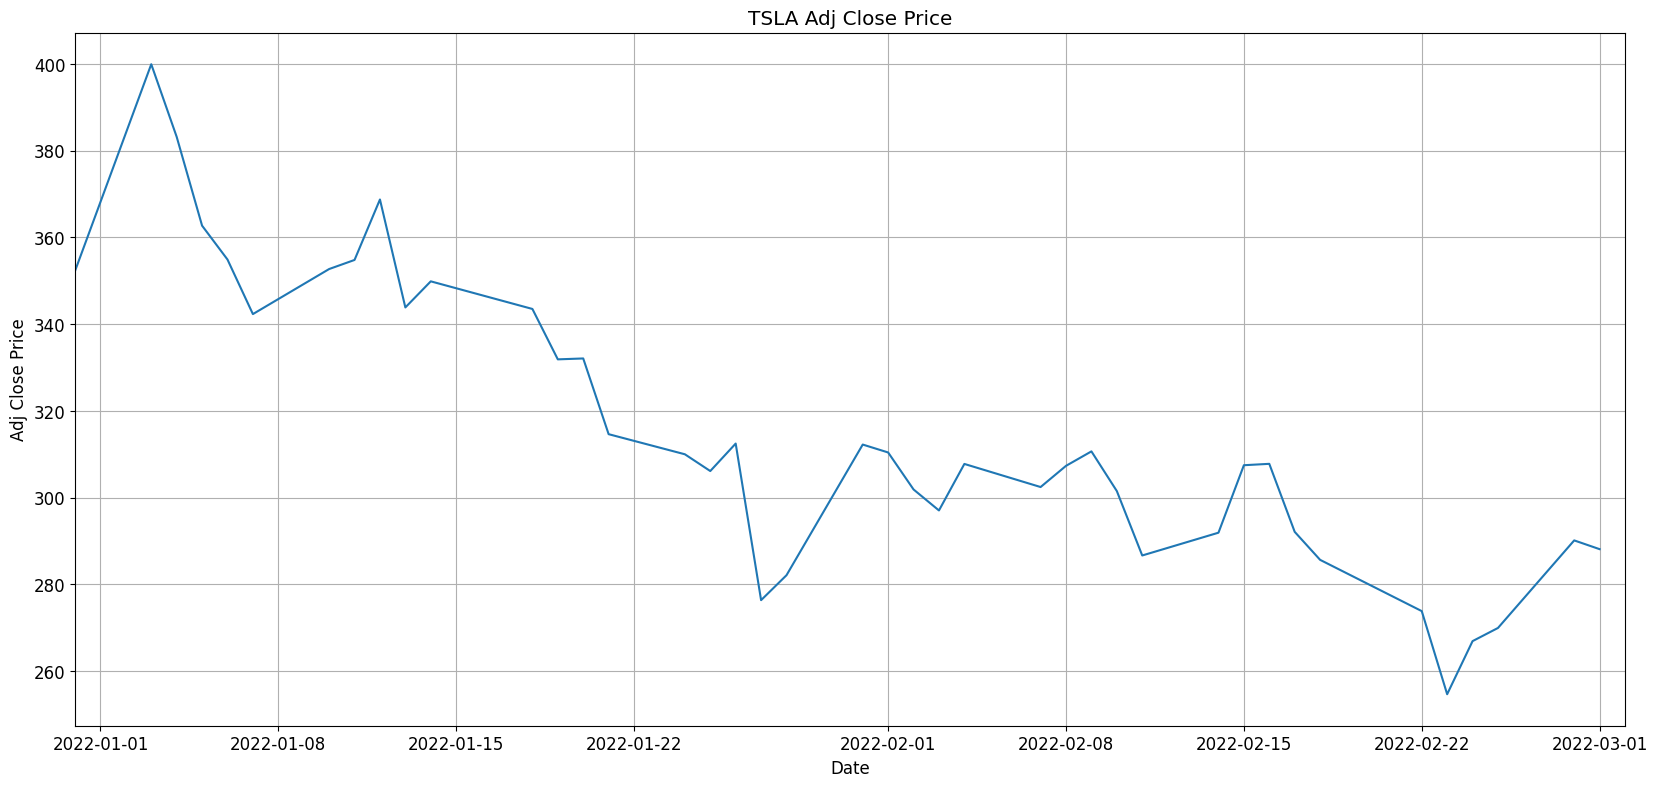

In [20]:
# plotting TSLA Adj Close price from 2022-01-01 to 2020-03-01
plt.plot(tsla_price_df.index, y)
plt.xlabel('Date')
plt.ylabel('Adj Close Price')
plt.xlim(start_time_all, end_time_all)


plt.title('TSLA Adj Close Price')
plt.show()

### 3. Normalizing and converting data

In [21]:
n_split = 20 # where to split training and validation datasets 

## SCALING THE DATASET

In [22]:
# normalizing datasets
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)
y_norm = scaler.fit_transform(y.values.reshape(-1, 1))

# training using Jan - Sep data
# validating trained model using Oct - Dec data
X_train = X_norm[:n_split, :]
y_train = y_norm[:n_split, :]

print('Training Set Shape ', X_train.shape, y_train.shape)

Training Set Shape  (20, 5) (20, 1)


In [23]:
y

Date
2021-12-31    352.260010
2022-01-03    399.926666
2022-01-04    383.196655
2022-01-05    362.706665
2022-01-06    354.899994
2022-01-07    342.320007
2022-01-10    352.706665
2022-01-11    354.799988
2022-01-12    368.739990
2022-01-13    343.853333
2022-01-14    349.869995
2022-01-18    343.503326
2022-01-19    331.883331
2022-01-20    332.089996
2022-01-21    314.633331
2022-01-24    310.000000
2022-01-25    306.133331
2022-01-26    312.470001
2022-01-27    276.366669
2022-01-28    282.116669
2022-01-31    312.239990
2022-02-01    310.416656
2022-02-02    301.886658
2022-02-03    297.046661
2022-02-04    307.773346
2022-02-07    302.446655
2022-02-08    307.333344
2022-02-09    310.666656
2022-02-10    301.516663
2022-02-11    286.666656
2022-02-14    291.920013
2022-02-15    307.476654
2022-02-16    307.796661
2022-02-17    292.116669
2022-02-18    285.660004
2022-02-22    273.843323
2022-02-23    254.679993
2022-02-24    266.923340
2022-02-25    269.956665
2022-02-28    290.14

## CONVERSION TO TENSORS

In [24]:
import torch
import numpy as np
import pandas as pd


# Assuming X_train and y_train are your training data
# X_val is your validation data, y_true is the true labels for validation set

# Convert pandas DataFrame/Series to numpy arrays if not already done
X_train_np = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
y_train_np = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train
X_val_np = X_norm.to_numpy() if isinstance(X_norm, pd.DataFrame) else X_norm
y_val_np = y_norm.to_numpy() if isinstance(y_norm, pd.DataFrame) else y_norm
y_true_np = y.to_numpy().flatten() if isinstance(y, pd.DataFrame) else np.array(y).flatten()

# Convert numpy arrays to tensors
X_train_tensors = torch.tensor(X_train_np, dtype=torch.float32)
y_train_tensors = torch.tensor(y_train_np, dtype=torch.float32)
X_val_tensors = torch.tensor(X_val_np, dtype=torch.float32)
y_val_tensors = torch.tensor(y_val_np, dtype=torch.float32)
y_true_tensors = torch.tensor(y_true_np, dtype=torch.float32)  # Ensure y_true is a 1D array

# Reshape X tensors to 3D format: (batch_size, sequence_length, input_size)
X_train_tensors = X_train_tensors.view(X_train_tensors.shape[0], 1, X_train_tensors.shape[1])
X_val_tensors = X_val_tensors.view(X_val_tensors.shape[0], 1, X_val_tensors.shape[1])

# Print the shapes of the tensors
print('Training Set Shape   ', X_train_tensors.shape, y_train_tensors.shape)
print('Validation Set Shape ', X_val_tensors.shape, y_true_tensors.shape)

Training Set Shape    torch.Size([20, 1, 5]) torch.Size([20, 1])
Validation Set Shape  torch.Size([41, 1, 5]) torch.Size([41])


In [25]:
y_true_np 

array([352.26000977, 399.92666626, 383.19665527, 362.70666504,
       354.8999939 , 342.32000732, 352.70666504, 354.79998779,
       368.73999023, 343.85333252, 349.86999512, 343.50332642,
       331.8833313 , 332.08999634, 314.6333313 , 310.        ,
       306.1333313 , 312.47000122, 276.3666687 , 282.1166687 ,
       312.23999023, 310.41665649, 301.88665771, 297.04666138,
       307.77334595, 302.44665527, 307.33334351, 310.66665649,
       301.5166626 , 286.66665649, 291.92001343, 307.47665405,
       307.79666138, 292.1166687 , 285.66000366, 273.84332275,
       254.67999268, 266.92333984, 269.95666504, 290.14334106,
       288.12332153])

In [26]:
# selecting gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")            

In [27]:
# function for calculating MSE (Mean Squared Error)
def calc_mse(y_true, y_hat):
    mse = float(sum((y_true - y_hat) * (y_true - y_hat)) / len(y_hat))
    return mse

## LSTM REGRESSOR AND GRIDSEARCH-CV

In [28]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import GridSearchCV
import numpy as np
import random


# Set random seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(797)


# Define the LSTM model
class LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM_model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(x.device)
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Define the custom LSTM regressor
class LSTMRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, hidden_size=1, learning_rate=0.001, num_epochs=1000, num_layers=1, patience=100, validation_split=0.2):
        self.hidden_size = hidden_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.num_layers = num_layers
        self.patience = patience
        self.validation_split = validation_split
        self.model = None

    def fit(self, X_tensor, y_tensor):
        # Assuming X_tensor is of shape (batch_size, seq_length, input_size)
        # and y_tensor is of shape (batch_size, 1)

        # Split the data into training and validation sets
        n_train = int((1 - self.validation_split) * len(X_tensor))
        X_train, X_val = X_tensor[:n_train], X_tensor[n_train:]
        y_train, y_val = y_tensor[:n_train], y_tensor[n_train:]

        input_size = X_tensor.shape[2]
        num_classes = 1

        self.model = LSTM_model(input_size, self.hidden_size, self.num_layers, num_classes)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        loss_function = torch.nn.MSELoss()

        # Training loop with early stopping
        self.model.train()
        best_val_loss = float('inf')
        patience_counter = 0

        for epoch in range(self.num_epochs):
            # Training step
            self.model.train()
            optimizer.zero_grad()
            outputs = self.model(X_train)
            train_loss = loss_function(outputs, y_train)
            train_loss.backward()
            optimizer.step()

            # Validation step
            self.model.eval()
            with torch.no_grad():
                val_outputs = self.model(X_val)
                val_loss = loss_function(val_outputs, y_val)

            # Early stopping logic
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= self.patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        return self

    def predict(self, X_tensor):
        self.model.eval()
        with torch.no_grad():
            y_pred = self.model(X_tensor)
        return y_pred.numpy().flatten()

param_grid = {
    'hidden_size': [1, 2, 3, 4, 5],
    'learning_rate': [0.01, 0.001],
    'num_layers': [1, 2, 3, 4, 5]
}

# Initialize the custom estimator with a fixed number of epochs and early stopping patience
lstm_regressor = LSTMRegressor(num_epochs=1000, patience=200, validation_split=0.2)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=lstm_regressor, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)

# Fit the model
grid_search.fit(X_train_tensors, y_train_tensors)

# Get the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Early stopping at epoch 553
Early stopping at epoch 250
Early stopping at epoch 318
Early stopping at epoch 219
Early stopping at epoch 655
Early stopping at epoch 292
Early stopping at epoch 283
Early stopping at epoch 244
Early stopping at epoch 291
Early stopping at epoch 380
Early stopping at epoch 273
Early stopping at epoch 364
Early stopping at epoch 265
Early stopping at epoch 263
Early stopping at epoch 440
Early stopping at epoch 201
Early stopping at epoch 543
Early stopping at epoch 740
Early stopping at epoch 613
Early stopping at epoch 211
Early stopping at epoch 594
Early stopping at epoch 724
Early stopping at epoch 201
Early stopping at epoch 906
Early stopping at epoch 494
Early stopping at epoch 937
Early stopping at epoch 473
Early stopping at epoch 264
Early stopping at epoch 258
Early stopping at epoch 212
Early stopping at epoch 244
Early stopping at epoch 270
Early stopping at epoch 206
Early stopping at epoch 242
Early stopping at epoch 232
Early stopping at ep

In [29]:
# best hyperparameters
best_params = grid_search.best_estimator_

# Assuming best_params is an estimator object from grid_search
params_dict = best_params.get_params()

print(params_dict)
best_params=params_dict

{'hidden_size': 3, 'learning_rate': 0.01, 'num_epochs': 1000, 'num_layers': 1, 'patience': 200, 'validation_split': 0.2}


## TESTING ON BEST LSTM MODEL

Epoch 0/10000, Train MSE: 1.3213891983032227, Val MSE: 0.7082082033157349


<ipython-input-30-00efb09b085f>:92: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mse = float(sum((y_true - y_hat) * (y_true - y_hat)) / len(y_hat))


Epoch 100/10000, Train MSE: 0.016146205365657806, Val MSE: 0.018957063555717468
Epoch 200/10000, Train MSE: 0.007561179809272289, Val MSE: 0.01616159826517105
Epoch 300/10000, Train MSE: 0.005507194437086582, Val MSE: 0.010923158377408981
Epoch 400/10000, Train MSE: 0.004269378259778023, Val MSE: 0.006110334303230047
Epoch 500/10000, Train MSE: 0.0031779310666024685, Val MSE: 0.0027331667952239513
Epoch 600/10000, Train MSE: 0.0023307304363697767, Val MSE: 0.0008421540260314941
Epoch 700/10000, Train MSE: 0.0018651785794645548, Val MSE: 0.000284458976238966
Epoch 800/10000, Train MSE: 0.0016857062000781298, Val MSE: 0.00031146936817094684
Epoch 900/10000, Train MSE: 0.0015921652084216475, Val MSE: 0.00039936183020472527
Epoch 1000/10000, Train MSE: 0.0015086124185472727, Val MSE: 0.0004733007517643273
Epoch 1100/10000, Train MSE: 0.0014150243951007724, Val MSE: 0.0005377464112825692
Epoch 1200/10000, Train MSE: 0.0013017787132412195, Val MSE: 0.000605611247010529
Epoch 1300/10000, Trai

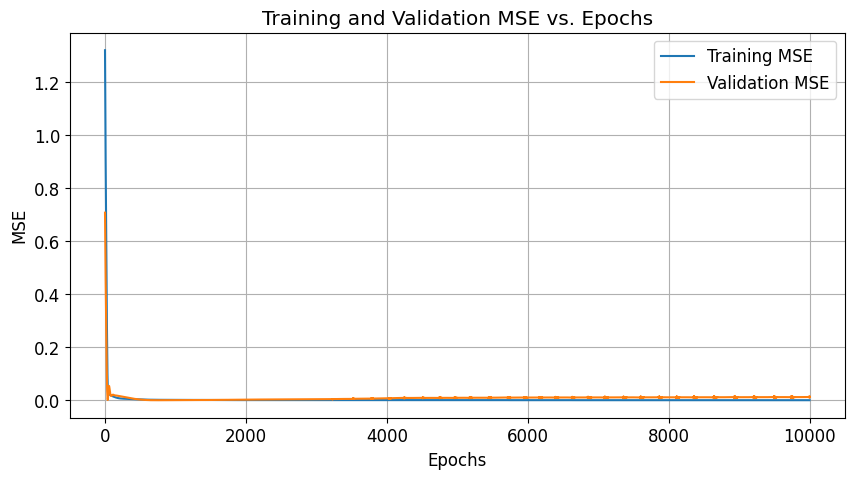

Validation Predictions (First 10): [0.66478133 0.97984815 0.86760205 0.72504663 0.6414437  0.58930504
 0.65607566 0.6557641  0.80400217 0.62268597]
Best hyperparameters have been used to train the model.


In [30]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import random
import matplotlib.pyplot as plt


# Define the LSTM model
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(797)

class LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM_model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(x.device)
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Define the custom estimator for GridSearchCV
class LSTMRegressor:
    def __init__(self, hidden_size=1, num_layers=1, learning_rate=0.001, num_epochs=10000):
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.model = None
        self.device = torch.device('cpu')
        self.train_mse = []
        self.val_mse = []

    def fit(self, X_train, y_train, X_val, y_val):
        input_size = X_train.shape[2]  # Number of features
        num_classes = y_train.shape[1]  # Number of output classes
        self.model = LSTM_model(input_size, self.hidden_size, self.num_layers, num_classes).to(self.device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        loss_function = torch.nn.MSELoss()

        for epoch in range(self.num_epochs):
            self.model.train()
            optimizer.zero_grad()
            outputs = self.model(X_train)
            train_loss = loss_function(outputs, y_train)
            train_loss.backward()
            optimizer.step()

            self.model.eval()
            with torch.no_grad():
                val_outputs = self.model(X_val)
                val_loss = loss_function(val_outputs, y_val)

            # Convert tensors to numpy for MSE calculation
            y_train_np = y_train.cpu().numpy()
            outputs_np = outputs.cpu().detach().numpy()
            y_val_np = y_val.cpu().numpy()
            val_outputs_np = val_outputs.detach().cpu().numpy()

            train_mse = calc_mse(y_train_np, outputs_np)
            val_mse = calc_mse(y_val_np, val_outputs_np)

            self.train_mse.append(train_mse)
            self.val_mse.append(val_mse)

            if epoch % 100 == 0:
                print(f'Epoch {epoch}/{self.num_epochs}, Train MSE: {train_mse}, Val MSE: {val_mse}')

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(X)
        return predictions

def calc_mse(y_true, y_hat):
    mse = float(sum((y_true - y_hat) * (y_true - y_hat)) / len(y_hat))
    return mse

# Assuming you have X_train_tensors, y_train_tensors, X_val_tensors, y_val_tensors ready



# Specify the number of epochs you want to train the model
num_epochs = 10000

# Initialize the model with the best hyperparameters
best_model = LSTMRegressor(
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    num_epochs=num_epochs

)
X_val_tensors_val=X_val_tensors[n_split:n_split+5,:]
y_val_tensors_val=y_val_tensors[n_split:n_split+5,:]
# Fit the model using the training data and validation data
best_model.fit(X_train_tensors, y_train_tensors, X_val_tensors_val, y_val_tensors_val)

# Plot training and validation MSE
epochs = range(1, best_model.num_epochs + 1)
plt.figure(figsize=(10, 5))
plt.plot(epochs, best_model.train_mse, label='Training MSE')
plt.plot(epochs, best_model.val_mse, label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.title('Training and Validation MSE vs. Epochs')
plt.show()

# Make predictions and inverse transform (assuming scaler is defined)
y_hat = best_model.predict(X_val_tensors)
y_hat = y_hat.data.detach().cpu().numpy()  # numpy conversion

# Print some validation predictions for inspection
print("Validation Predictions (First 10):", y_hat.flatten()[:10])

# Optionally, save the trained model state
torch.save(best_model.model.state_dict(), 'best_model_state.pth')

print("Best hyperparameters have been used to train the model.")


In [31]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import random
import matplotlib.pyplot as plt

# Define the LSTM model
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(797)

class LSTM_model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(LSTM_model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(x.device)
        c0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Define the custom estimator for GridSearchCV
class LSTMRegressor:
    def __init__(self, hidden_size=2, num_layers=1, learning_rate=0.001, num_epochs=10000):
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.model = None
        self.device = torch.device('cpu')
        self.train_mse = []
        self.val_mse = []

    def fit(self, X_train, y_train, X_val, y_val):
        input_size = X_train.shape[2]  # Number of features
        num_classes = y_train.shape[1]  # Number of output classes
        self.model = LSTM_model(input_size, self.hidden_size, self.num_layers, num_classes).to(self.device)
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)
        loss_function = torch.nn.MSELoss()

        for epoch in range(self.num_epochs):
            self.model.train()
            optimizer.zero_grad()
            outputs = self.model(X_train)
            train_loss = loss_function(outputs, y_train)
            train_loss.backward()
            optimizer.step()

            self.model.eval()
            with torch.no_grad():
                val_outputs = self.model(X_val)
                val_loss = loss_function(val_outputs, y_val)

            # Convert tensors to numpy for MSE calculation
            y_train_np = y_train.cpu().numpy()
            outputs_np = outputs.cpu().detach().numpy()
            y_val_np = y_val.cpu().numpy()
            val_outputs_np = val_outputs.cpu().detach().numpy()

            train_mse = calc_mse(y_train_np, outputs_np)
            val_mse = calc_mse(y_val_np, val_outputs_np)

            self.train_mse.append(train_mse)
            self.val_mse.append(val_mse)

            if epoch % 50 == 0:
                print(f'Epoch {epoch}/{self.num_epochs}, Train MSE: {train_mse}, Val MSE: {val_mse}')

    def predict(self, X):
        self.model.eval()
        with torch.no_grad():
            predictions = self.model(X)
        return predictions

def calc_mse(y_true, y_hat):
    mse = float(sum((y_true - y_hat) * (y_true - y_hat)) / len(y_hat))
    return mse



# Specify the number of epochs you want to train the model
num_epochs = 4201

# Initialize the model with the best hyperparameters
best_model = LSTMRegressor(
     hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    learning_rate=best_params['learning_rate'],
    num_epochs=num_epochs
)
X_val_tensors_test=X_val_tensors[n_split+5:,:]
y_val_tensors_test=y_val_tensors[n_split+5:,:]
# Fit the model using the training data and validation data
best_model.fit(X_train_tensors, y_train_tensors, X_val_tensors, y_val_tensors)



# Make predictions and inverse transform (assuming scaler is defined)
y_hat = best_model.predict(X_val_tensors)
y_hat = y_hat.data.detach().cpu().numpy()  # numpy conversion
# Assuming scaler is previously defined and used for inverse transformation
y_hat = scaler.inverse_transform(y_hat)



# Print some validation predictions for inspection
print("Validation Predictions (First 10):", y_hat.flatten()[:10])
# Assuming y_true_np is defined
# print("True Values (First 10):", y_true_np.flatten()[:10])

# Calculate MSE (assuming calc_mse is defined)
mse = calc_mse(y_true_np.flatten(), y_hat.flatten())
print(f'MSE: {mse}')

# Optionally, save the trained model state
torch.save(best_model.model.state_dict(), 'best_model_state.pth')

print("Best hyperparameters have been used to train the model.")

Epoch 0/4201, Train MSE: 1.3213891983032227, Val MSE: 0.9115844368934631
Epoch 50/4201, Train MSE: 0.02331877499818802, Val MSE: 0.04765266180038452


<ipython-input-31-393bec66d053>:91: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  mse = float(sum((y_true - y_hat) * (y_true - y_hat)) / len(y_hat))


Epoch 100/4201, Train MSE: 0.016146205365657806, Val MSE: 0.027646657079458237
Epoch 150/4201, Train MSE: 0.010878227651119232, Val MSE: 0.023091213777661324
Epoch 200/4201, Train MSE: 0.007561179809272289, Val MSE: 0.019046353176236153
Epoch 250/4201, Train MSE: 0.006228307262063026, Val MSE: 0.016032559797167778
Epoch 300/4201, Train MSE: 0.005507194437086582, Val MSE: 0.013304070569574833
Epoch 350/4201, Train MSE: 0.004871529992669821, Val MSE: 0.010817847214639187
Epoch 400/4201, Train MSE: 0.004269378259778023, Val MSE: 0.00860598310828209
Epoch 450/4201, Train MSE: 0.003701844485476613, Val MSE: 0.006667644716799259
Epoch 500/4201, Train MSE: 0.0031779310666024685, Val MSE: 0.005011638626456261
Epoch 550/4201, Train MSE: 0.0027135328855365515, Val MSE: 0.0036622050683945417
Epoch 600/4201, Train MSE: 0.0023307304363697767, Val MSE: 0.0026523408014327288
Epoch 650/4201, Train MSE: 0.0020485161803662777, Val MSE: 0.0019917860627174377
Epoch 700/4201, Train MSE: 0.00186517857946455

In [32]:
print(len(y_hat))
print(len(X_val_tensors))

print(len(X_train_tensors))



41
41
20


## RESULTS

In [33]:
# function for plotting actual and predicted Adj Close price
def plt_graph(start_time, end_time, period, val_line=False):
    # plotting actual Adj Close price
    plt.plot(tsla_price_df.index, y_true_tensors, label='Actual Price')
    # plotting predicted Adj Close price
    plt.plot(tsla_price_df.index, y_hat, label='Pred Price')
    if val_line:
        plt.axvline(x=start_time_val, c='r', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Adj Close Price')
    plt.xlim(start_time, end_time)
    plt.title(f'{period} Period')
    plt.legend()
    plt.show()

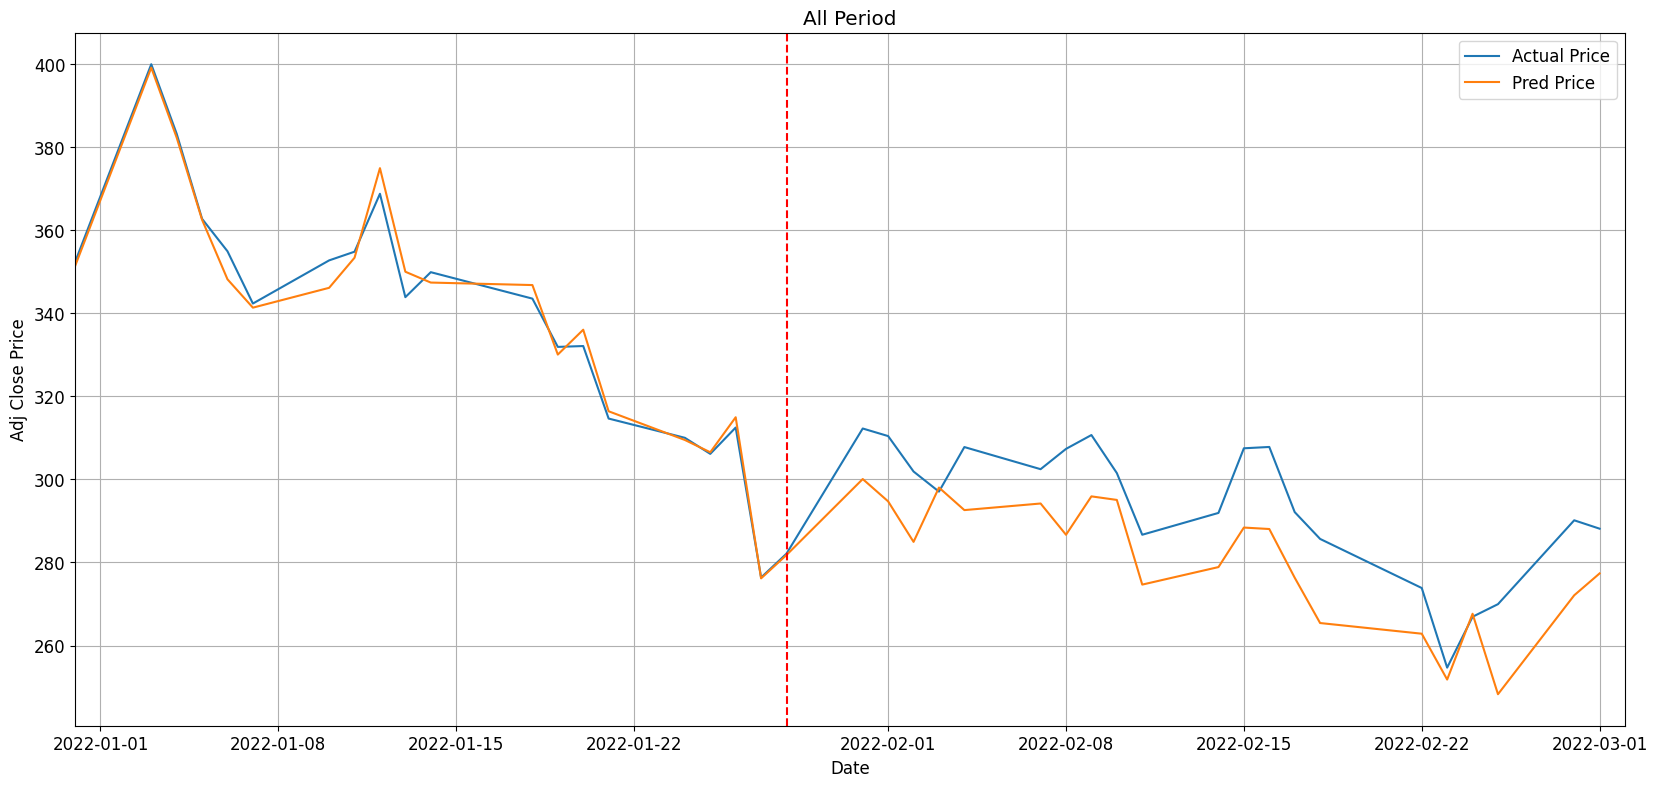

In [34]:
# plotting all period
period = 'All'
plt_graph(start_time_all, end_time_all, period, True)

In [35]:
print(len(y_hat))

41
